In [7]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Path of a Folder
data_folder = "assignment/asset_1" 

# Step 1: Load Data
def load_data(folder_path):
    """
    Load Axial, Vertical, and Horizontal data for each timestamp from JSON files.
    Combine data into a single structure for further processing.
    """
    combined_data = []
    timestamps = set()
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".json"):
            with open(os.path.join(folder_path, file_name), "r") as file:
                data = json.load(file)
                combined_data.append(data)
                timestamps.add(data["timestamp"])
    
    # Group by timestamp
    grouped_data = {}
    for ts in timestamps:
        grouped_data[ts] = {
            "Axial": None,
            "Vertical": None,
            "Horizontal": None
        }
    for entry in combined_data:
        grouped_data[entry["timestamp"]][entry["axis"]] = entry["raw_data"]
    
    return grouped_data

# Step 2: Preprocess Data
def preprocess_data(grouped_data):
    """
    Normalize and combine data for clustering.
    """
    processed_data = []
    for ts, axes_data in grouped_data.items():
        if None not in axes_data.values():  # Ensure all axes are available
            # Combine Axial, Vertical, Horizontal data for the timestamp
            combined = np.hstack([
                axes_data["Axial"],
                axes_data["Vertical"],
                axes_data["Horizontal"]
            ])
            processed_data.append(combined)
    
    # Convert to numpy array
    processed_data = np.array(processed_data)

    # Normalize the data
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(processed_data)
    
    return normalized_data

# Step 3: Clustering
def perform_clustering(data, n_clusters=3):
    """
    Perform clustering using K-Means.
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(data)
    return labels

# Step 4: Dimensionality Reduction and Visualization
def visualize_clusters(data, labels, method="pca"):
    """
    Visualize clusters using PCA
    """
    if method == "pca":
        reducer = PCA(n_components=2)
    else:
        raise ValueError("Unsupported dimensionality reduction method")
    
    reduced_data = reducer.fit_transform(data)

    plt.figure(figsize=(10, 8))
    for label in np.unique(labels):
        cluster_data = reduced_data[labels == label]
        plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f"Cluster {label}")
    plt.legend()
    plt.title("Cluster Visualization")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()

# Step 5: Visualize Raw Data for a Single Timestamp
def visualize_raw_data(grouped_data, timestamp):
    """
    Plot raw Axial, Vertical, and Horizontal data for a given timestamp.
    """
    if timestamp not in grouped_data:
        print("Timestamp not found in data.")
        return
    
    data = grouped_data[timestamp]
    if None in data.values():
        print("Incomplete data for the given timestamp.")
        return

    plt.figure(figsize=(15, 5))
    plt.plot(data["Axial"], label="Axial", alpha=0.7)
    plt.plot(data["Vertical"], label="Vertical", alpha=0.7)
    plt.plot(data["Horizontal"], label="Horizontal", alpha=0.7)
    plt.title(f"Raw Data for Timestamp {timestamp}")
    plt.xlabel("Sample Index")
    plt.ylabel("Vibration Amplitude")
    plt.legend()
    plt.show()

In [8]:
grouped_data = load_data(data_folder)

In [9]:
processed_data = preprocess_data(grouped_data)

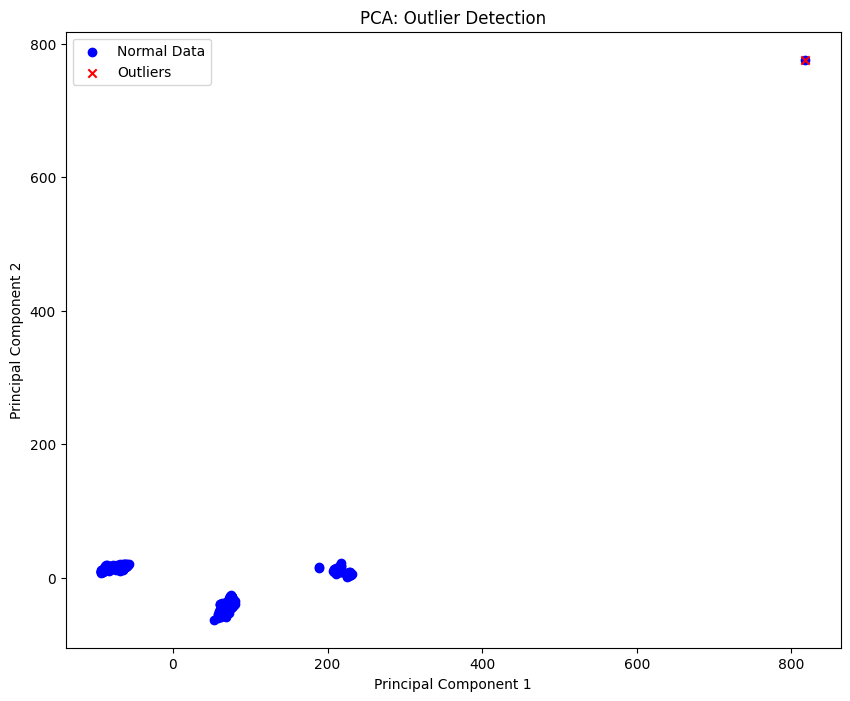

Outlier Indices: [63]


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Used to Delete Outliers
def detect_outliers_pca(processed_data, percentile_threshold=99.9, plot=True):
    # Normalize the data
    scaler = StandardScaler()
    processed_data_normalized = scaler.fit_transform(processed_data)

    # Apply PCA
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(processed_data_normalized)

    # Compute the centroid (mean of the data in PCA space)
    centroid = np.mean(reduced_data, axis=0)

    # Calculate the Euclidean distance of each point from the centroid
    distances = np.linalg.norm(reduced_data - centroid, axis=1)

    # Set a threshold for outlier detection (e.g., 95th percentile distance)
    threshold = np.percentile(distances, percentile_threshold)

    # Identify the outliers (points that are farther than the threshold distance from the centroid)
    outliers = np.where(distances > threshold)[0]

    if plot:
        # Visualize the data with outliers highlighted
        plt.figure(figsize=(10, 8))
        plt.scatter(reduced_data[:, 0], reduced_data[:, 1], label='Normal Data', color='b')
        plt.scatter(reduced_data[outliers, 0], reduced_data[outliers, 1], label='Outliers', color='r', marker='x')
        plt.title("PCA: Outlier Detection")
        plt.xlabel("Principal Component 1")
        plt.ylabel("Principal Component 2")
        plt.legend()
        plt.show()

    return outliers

# Example usage:
outliers = detect_outliers_pca(processed_data, plot=True)
print("Outlier Indices:", outliers)


In [11]:
# Remove outliers from the dataset
processed_data_clean = np.delete(processed_data, outliers, axis=0)

In [12]:
wcss = []

for i in range(1,11):
  kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
  kmeans.fit(processed_data_clean)

  wcss.append(kmeans.inertia_)

C:\Users\vinay\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\vinay\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\vinay\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\vinay\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The defa

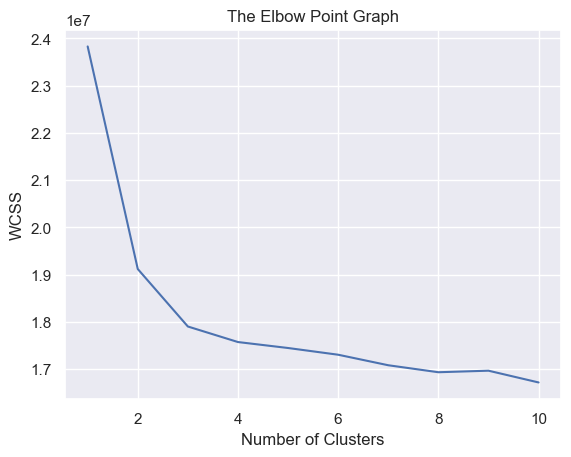

In [13]:
# plot an elbow graph
import seaborn as sns
sns.set()
plt.plot(range(1,11), wcss)
plt.title('The Elbow Point Graph')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [14]:
cluster_labels = perform_clustering(processed_data_clean, n_clusters=4)

C:\Users\vinay\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


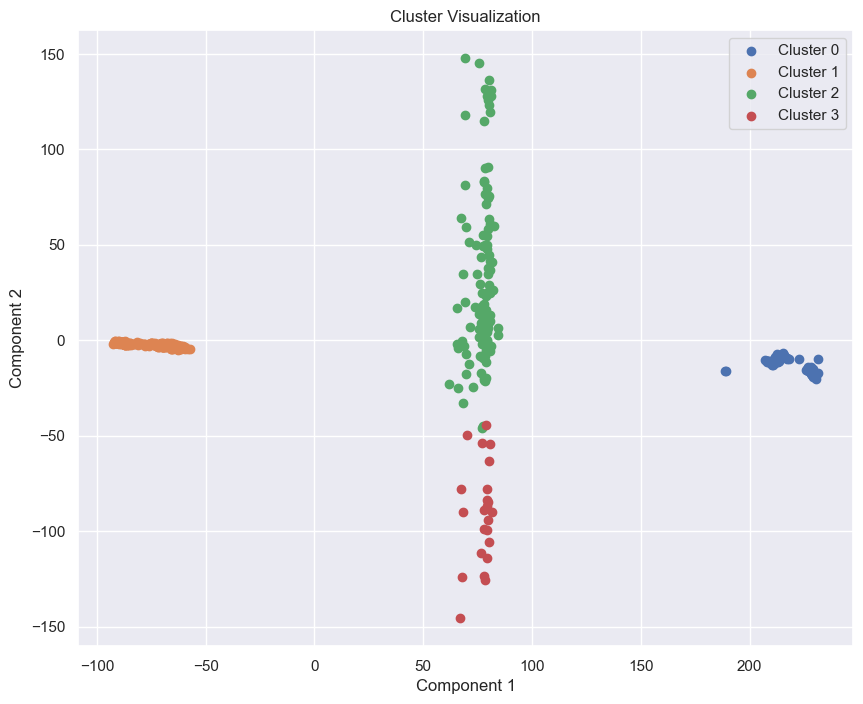

In [15]:
# Visualize clusters
visualize_clusters(processed_data_clean, cluster_labels, method="pca")

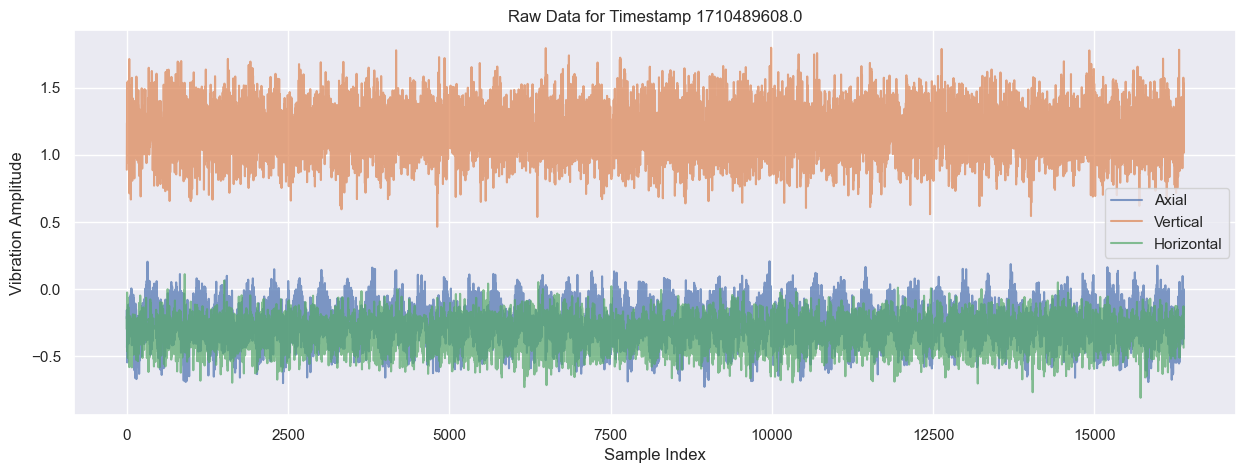

In [16]:
# Visualize raw data for a specific timestamp
example_timestamp = list(grouped_data.keys())[0]  # Use the first timestamp as an example
visualize_raw_data(grouped_data, example_timestamp)


In [17]:
print("Cluster Analysis:")
unique_labels, counts = np.unique(cluster_labels, return_counts=True)
for label, count in zip(unique_labels, counts):
    print(f"Cluster {label}: {count} timestamps")

Cluster Analysis:
Cluster 0: 59 timestamps
Cluster 1: 311 timestamps
Cluster 2: 118 timestamps
Cluster 3: 23 timestamps


### Cluster Summary
1. Cluster 0: Contains 59 timestamps, which might represent a smaller, possibly more specific subgroup within your data. This cluster may        contain timestamps that share distinct characteristics or trends.
2. Cluster 1: With 311 timestamps, this is the largest cluster and likely represents the most common or dominant pattern in your data. The       timestamps here could correspond to the main behavior or attribute in the dataset.
3. Cluster 2: Includes 118 timestamps, which suggests it represents a moderately significant group with potentially unique but less common       attributes than Cluster 1.
4. Cluster 3: Contains 23 timestamps, the smallest cluster, which might indicate an outlier group or timestamps with highly specific and         uncommon traits.
### Potential Patterns or Insights
1. Dominance of Cluster 1: The high count of 311 timestamps in Cluster 1 suggests this group may represent the "default" or most frequent        behavior in your dataset. Look into the features or attributes of these timestamps to understand why they dominate.
2. Small Clusters (0 and 3): Clusters 0 and 3 are relatively small, potentially representing outliers, anomalies, or niche behaviors. Further    investigation into these clusters can uncover unique patterns or areas of interest.
3. Intermediate Group (Cluster 2): Cluster 2 might act as a bridge between common patterns (Cluster 1) and niche ones (Clusters 0 and 3),        offering insights into transitional or hybrid behaviors.
### Next Steps for AnalysisTime Trends:
1. Feature Comparison Across Clusters: Compare key features of the timestamps in each cluster to identify the defining characteristics of each group.
2. Time Trends: If timestamps have a temporal sequence, analyze whether certain clusters dominate during specific periods.
3. Practical Implications: Relate the clusters to real-world phenomena or use cases (e.g., peak activity times, rare events, etc.).